### Method 1
do for every day\
    find number of catches (N), randomly pick N points within the region making sure that they are (d) distance away from any catch and not on land (i.e. they are valid in copcus ds)\
    for every catch location, extract all variables from phy and bio dataset 

# Correlation Analysis for Mackerel Catch Prediction

Let's analyze the environmental factors that are most predictive of mackerel catches. We'll examine correlations, feature importance, and statistical relationships.

In [1]:
import datetime 
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from utilities import plot_date_distribution, get_region_border

METHOD1_PATH = '/home/anna/msc_oppgave/fish-forecast/correlation_dataset_method1_full_wVMS.csv'
corrrolation_dataset = pd.read_csv(METHOD1_PATH, sep=';', low_memory=False)

# remove any coloumns named model_depth
corrrolation_dataset = corrrolation_dataset.loc[:, ~corrrolation_dataset.columns.str.contains('model_depth')]

print(f"Loaded correlation dataset: {corrrolation_dataset.shape}")
print(f"Columns: {list(corrrolation_dataset.columns)}")

/home/anna/msc_oppgave/fish-forecast/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded correlation dataset: (55580, 191)
Columns: ['Date', 'Latitude', 'Longitude', 'HasCatch', 'CatchWeight', 'bio_chl_depth_2.0', 'bio_chl_depth_3.0', 'bio_chl_depth_4.0', 'bio_chl_depth_5.0', 'bio_chl_depth_6.0', 'bio_chl_depth_8.0', 'bio_chl_depth_10.0', 'bio_chl_depth_11.0', 'bio_chl_depth_13.0', 'bio_chl_depth_16.0', 'bio_chl_depth_18.0', 'bio_chl_depth_22.0', 'bio_chl_depth_25.0', 'bio_chl_depth_29.0', 'bio_kd_depth_2.0', 'bio_kd_depth_3.0', 'bio_kd_depth_4.0', 'bio_kd_depth_5.0', 'bio_kd_depth_6.0', 'bio_kd_depth_8.0', 'bio_kd_depth_10.0', 'bio_kd_depth_11.0', 'bio_kd_depth_13.0', 'bio_kd_depth_16.0', 'bio_kd_depth_18.0', 'bio_kd_depth_22.0', 'bio_kd_depth_25.0', 'bio_kd_depth_29.0', 'bio_no3_depth_2.0', 'bio_no3_depth_3.0', 'bio_no3_depth_4.0', 'bio_no3_depth_5.0', 'bio_no3_depth_6.0', 'bio_no3_depth_8.0', 'bio_no3_depth_10.0', 'bio_no3_depth_11.0', 'bio_no3_depth_13.0', 'bio_no3_depth_16.0', 'bio_no3_depth_18.0', 'bio_no3_depth_22.0', 'bio_no3_depth_25.0', 'bio_no3_depth_29.0

In [2]:
# First, let's examine the structure and basic statistics of our dataset
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {corrrolation_dataset.shape}")
print(f"Columns: {len(corrrolation_dataset.columns)}")
print(f"\nFirst few columns: {list(corrrolation_dataset.columns[:10])}")

# Check the distribution of catch vs no-catch
catch_distribution = corrrolation_dataset['HasCatch'].value_counts()
print(f"\n=== CATCH DISTRIBUTION ===")
print(f"Catch records (HasCatch=1): {catch_distribution.get(1, 0)}")
print(f"No-catch records (HasCatch=0): {catch_distribution.get(0, 0)}")
print(f"Balance ratio: {catch_distribution.get(1, 0) / len(corrrolation_dataset):.2%}")

# Identify environmental variable columns
env_columns = [col for col in corrrolation_dataset.columns if col.startswith(('bio_', 'phy_'))]
print(f"\n=== ENVIRONMENTAL VARIABLES ===")
print(f"Total environmental variables: {len(env_columns)}")

# Separate bio and phy variables
bio_vars = [col for col in env_columns if col.startswith('bio_')]
phy_vars = [col for col in env_columns if col.startswith('phy_')]
print(f"Biological variables: {len(bio_vars)}")
print(f"Physical variables: {len(phy_vars)}")

# Check for missing values
missing_values = corrrolation_dataset[env_columns].isnull().sum()
print(f"\n=== DATA COMPLETENESS ===")
print(f"Variables with missing values: {(missing_values > 0).sum()}")
print(f"Average completeness: {(1 - missing_values.mean() / len(corrrolation_dataset)):.2%}")

# Display basic statistics
print(f"\n=== BASIC STATISTICS ===")
corrrolation_dataset[['Date', 'Latitude', 'Longitude', 'HasCatch', 'CatchWeight']].describe()

=== DATASET OVERVIEW ===
Dataset shape: (55580, 191)
Columns: 191

First few columns: ['Date', 'Latitude', 'Longitude', 'HasCatch', 'CatchWeight', 'bio_chl_depth_2.0', 'bio_chl_depth_3.0', 'bio_chl_depth_4.0', 'bio_chl_depth_5.0', 'bio_chl_depth_6.0']

=== CATCH DISTRIBUTION ===
Catch records (HasCatch=1): 27790
No-catch records (HasCatch=0): 27790
Balance ratio: 50.00%

=== ENVIRONMENTAL VARIABLES ===
Total environmental variables: 186
Biological variables: 126
Physical variables: 60

=== DATA COMPLETENESS ===
Variables with missing values: 186
Average completeness: 98.85%

=== BASIC STATISTICS ===


,Latitude,Longitude,HasCatch,CatchWeight
count,55580.000000,55580.000000,55580.000000,5.558000e+04
mean,62.575493,1.730065,0.500000,4.408858e+04
std,2.770877,2.394071,0.500004,9.494684e+04
min,57.667069,-3.166295,0.000000,0.000000e+00
25%,59.962259,-0.150000,0.000000,0.000000e+00
50%,62.927330,1.683225,0.500000,5.000000e-01
75%,64.417670,3.416972,1.000000,4.500000e+04
max,68.249923,7.415850,1.000000,1.020000e+06


In [3]:
# Calculate correlations between environmental variables and HasCatch
print("=== CORRELATION ANALYSIS ===")

# Get correlations with HasCatch (target variable)
correlations = corrrolation_dataset[env_columns + ['HasCatch']].corr()['HasCatch'].drop('HasCatch')

# Sort by absolute correlation value
correlations_abs = correlations.abs().sort_values(ascending=False)

# save all correlations to a CSV file
output_path = Path(METHOD1_PATH).parent / 'correlation_results_wVMS.csv'
correlation_df = pd.DataFrame({
    'Variable': correlations.index,
    'Correlation': correlations.values
})
correlation_df.to_csv(output_path, index=False)
print(f"\nCorrelation results saved to {output_path}")

print("Top 20 Most Correlated Environmental Variables with Mackerel Catch:")
print("=" * 70)
for i, (var, corr) in enumerate(correlations_abs.head(20).items(), 1):
    original_corr = correlations[var]
    direction = "↑" if original_corr > 0 else "↓"
    print(f"{i:2d}. {var:50s} {direction} {original_corr:7.4f} (|{corr:.4f}|)")

# Separate by variable type
bio_correlations = correlations_abs[correlations_abs.index.str.startswith('bio_')]
phy_correlations = correlations_abs[correlations_abs.index.str.startswith('phy_')]

print(f"\n=== TOP BIOLOGICAL VARIABLES ===")
for i, (var, corr) in enumerate(bio_correlations.head(10).items(), 1):
    original_corr = correlations[var]
    direction = "↑" if original_corr > 0 else "↓"
    print(f"{i:2d}. {var:50s} {direction} {original_corr:7.4f}")

print(f"\n=== TOP PHYSICAL VARIABLES ===")
for i, (var, corr) in enumerate(phy_correlations.head(10).items(), 1):
    original_corr = correlations[var]
    direction = "↑" if original_corr > 0 else "↓"
    print(f"{i:2d}. {var:50s} {direction} {original_corr:7.4f}")

=== CORRELATION ANALYSIS ===

Correlation results saved to /home/anna/msc_oppgave/fish-forecast/correlation_results_wVMS.csv
Top 20 Most Correlated Environmental Variables with Mackerel Catch:
 1. phy_thetao_depth_29.444730758666992                ↑  0.2538 (|0.2538|)
 2. phy_thetao_depth_25.211410522460938                ↑  0.2276 (|0.2276|)
 3. phy_thetao_depth_21.598819732666016                ↑  0.2093 (|0.2093|)
 4. phy_thetao_depth_18.495559692382812                ↑  0.1975 (|0.1975|)
 5. phy_thetao_depth_15.810070037841797                ↑  0.1895 (|0.1895|)
 6. phy_thetao_depth_13.467140197753906                ↑  0.1836 (|0.1836|)
 7. phy_thetao_depth_11.404999732971191                ↑  0.1794 (|0.1794|)
 8. phy_thetao_depth_9.572997093200684                 ↑  0.1765 (|0.1765|)
 9. phy_thetao_depth_7.92956018447876                  ↑  0.1745 (|0.1745|)
10. phy_thetao_depth_6.440614223480225                 ↑  0.1734 (|0.1734|)
11. phy_thetao_depth_5.078224182128906         

In [4]:
# Find minimum depth for each type
bio_depths = sorted({float(col.split('_')[-1]) for col in env_columns if col.startswith('bio_') and 'depth_' in col})
phy_depths = sorted({float(col.split('_')[-1]) for col in env_columns if col.startswith('phy_') and 'depth_' in col})

bio_first_depth = bio_depths[0]
phy_first_depth = phy_depths[0]

def is_depth(col, depth, prefix):
    if not col.startswith(prefix) or 'depth_' not in col:
        return False
    try:
        depth_val = float(col.split('_')[-1])
        return abs(depth_val - depth) < 1e-3
    except Exception:
        return False

bio_first_vars = [col for col in env_columns if is_depth(col, bio_first_depth, 'bio_')]
phy_first_vars = [col for col in env_columns if is_depth(col, phy_first_depth, 'phy_')]

bio_first_corrs = correlations[bio_first_vars].sort_values(key=abs, ascending=False)
phy_first_corrs = correlations[phy_first_vars].sort_values(key=abs, ascending=False)

print(f"Top correlations for the first BIO depth layer ({bio_first_depth}m):")
print("=" * 60)
for i, (var, corr) in enumerate(bio_first_corrs.items(), 1):
    direction = "↑" if corr > 0 else "↓"
    print(f"{i:2d}. {var:40s} {direction} {corr:7.4f}")

print(f"\nTop correlations for the first PHY depth layer ({phy_first_depth}m):")
print("=" * 60)
for i, (var, corr) in enumerate(phy_first_corrs.items(), 1):
    direction = "↑" if corr > 0 else "↓"
    print(f"{i:2d}. {var:40s} {direction} {corr:7.4f}")

Top correlations for the first BIO depth layer (2.0m):
 1. bio_o2_depth_2.0                         ↓ -0.1127
 2. bio_zooc_depth_2.0                       ↑  0.1023
 3. bio_po4_depth_2.0                        ↓ -0.0708
 4. bio_nppv_depth_2.0                       ↓ -0.0549
 5. bio_si_depth_2.0                         ↑  0.0276
 6. bio_phyc_depth_2.0                       ↑  0.0233
 7. bio_no3_depth_2.0                        ↑  0.0135
 8. bio_kd_depth_2.0                         ↑  0.0106
 9. bio_chl_depth_2.0                        ↓ -0.0106

Top correlations for the first PHY depth layer (0.49402499198913574m):
 1. phy_thetao_depth_0.49402499198913574     ↑  0.1706
 2. phy_uo_depth_0.49402499198913574         ↑  0.1136
 3. phy_so_depth_0.49402499198913574         ↑  0.0295
 4. phy_vo_depth_0.49402499198913574         ↑  0.0092


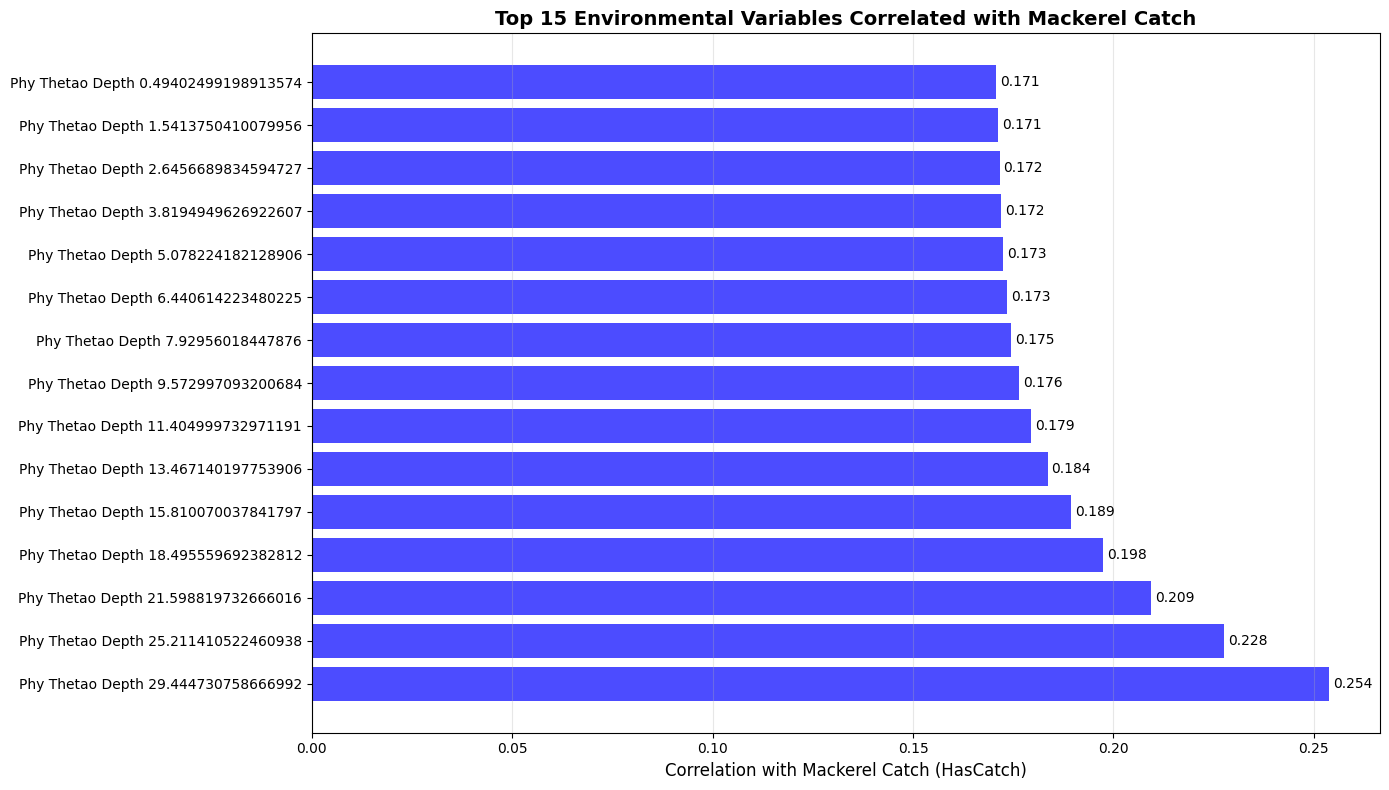

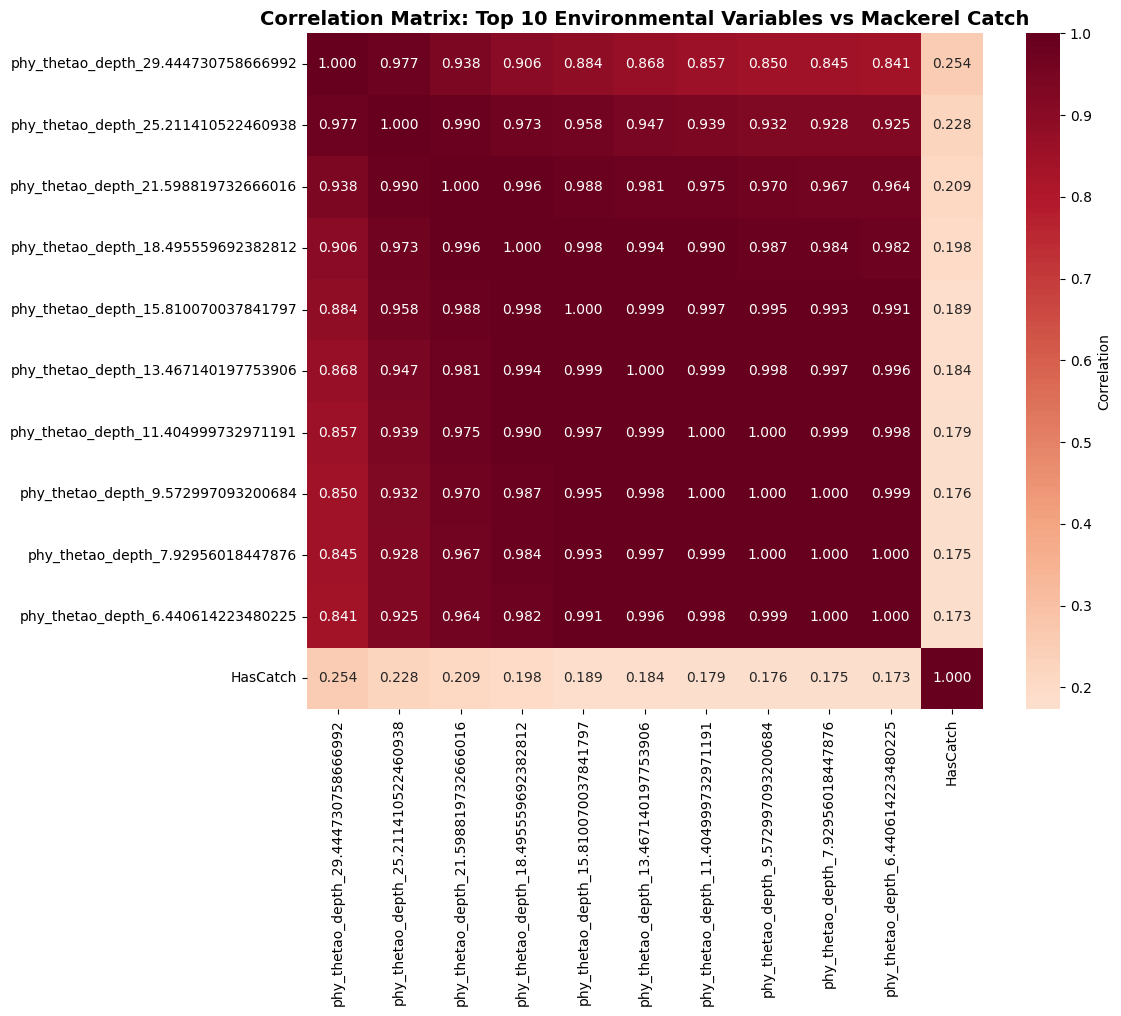

In [ ]:
# Visualize the top correlations
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization of top correlations
plt.figure(figsize=(14, 8))

# Top 15 correlations (both positive and negative)
top_correlations = correlations_abs.head(15)
top_corr_values = [correlations[var] for var in top_correlations.index]

# Create horizontal bar plot
colors = ['red' if x < 0 else 'blue' for x in top_corr_values]
bars = plt.barh(range(len(top_correlations)), top_corr_values, color=colors, alpha=0.7)

# Customize the plot
plt.yticks(range(len(top_correlations)), [var.replace('_', ' ').title() for var in top_correlations.index])
plt.xlabel('Correlation with Mackerel Catch (HasCatch)', fontsize=12)
plt.title('Top 15 Environmental Variables Correlated with Mackerel Catch', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_corr_values)):
    plt.text(val + (0.001 if val > 0 else -0.001), i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

# Create a correlation matrix heatmap for top variables
plt.figure(figsize=(12, 10))
top_vars = list(top_correlations.head(10).index) + ['HasCatch']
corr_matrix = corrrolation_dataset[top_vars].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: Top 10 Environmental Variables vs Mackerel Catch', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Analyze correlations by depth level
print("=== DEPTH-BASED ANALYSIS ===")

# Extract depth information from variable names
depth_analysis = {}

for var in env_columns:
    if 'depth_' in var:
        parts = var.split('_')
        if len(parts) >= 3:
            var_type = parts[0]  # bio or phy
            var_name = '_'.join(parts[1:-1])  # variable name
            depth = parts[-1]  # depth value
            
            if depth not in depth_analysis:
                depth_analysis[depth] = {'bio': [], 'phy': []}
            
            corr_val = abs(correlations[var])
            depth_analysis[depth][var_type].append((var, corr_val))

# Display results by depth
for depth in sorted(depth_analysis.keys(), key=lambda x: float(x) if x.replace('.', '').isdigit() else float('inf')):
    print(f"\n--- DEPTH {depth} m ---")
    
    # Sort and display bio variables
    if depth_analysis[depth]['bio']:
        bio_sorted = sorted(depth_analysis[depth]['bio'], key=lambda x: x[1], reverse=True)
        print(f"Top Biological variables at {depth}m:")
        for i, (var, corr) in enumerate(bio_sorted[:3], 1):
            original_corr = correlations[var]
            direction = "↑" if original_corr > 0 else "↓"
            print(f"  {i}. {var.replace('_', ' '):40s} {direction} {original_corr:7.4f}")
    
    # Sort and display phy variables
    if depth_analysis[depth]['phy']:
        phy_sorted = sorted(depth_analysis[depth]['phy'], key=lambda x: x[1], reverse=True)
        print(f"Top Physical variables at {depth}m:")
        for i, (var, corr) in enumerate(phy_sorted[:3], 1):
            original_corr = correlations[var]
            direction = "↑" if original_corr > 0 else "↓"
            print(f"  {i}. {var.replace('_', ' '):40s} {direction} {original_corr:7.4f}")

=== DEPTH-BASED ANALYSIS ===

--- DEPTH 0.49402499198913574 m ---
Top Physical variables at 0.49402499198913574m:
  1. phy thetao depth 0.49402499198913574     ↑  0.1706
  2. phy uo depth 0.49402499198913574         ↑  0.1136
  3. phy so depth 0.49402499198913574         ↑  0.0295

--- DEPTH 1.5413750410079956 m ---
Top Physical variables at 1.5413750410079956m:
  1. phy thetao depth 1.5413750410079956      ↑  0.1711
  2. phy uo depth 1.5413750410079956          ↑  0.1140
  3. phy so depth 1.5413750410079956          ↑  0.0295

--- DEPTH 2.0 m ---
Top Biological variables at 2.0m:
  1. bio o2 depth 2.0                         ↓ -0.1127
  2. bio zooc depth 2.0                       ↑  0.1023
  3. bio po4 depth 2.0                        ↓ -0.0708

--- DEPTH 2.6456689834594727 m ---
Top Physical variables at 2.6456689834594727m:
  1. phy thetao depth 2.6456689834594727      ↑  0.1716
  2. phy uo depth 2.6456689834594727          ↑  0.1140
  3. phy so depth 2.6456689834594727          ↑  

In [7]:
# Statistical significance testing
from scipy import stats
import numpy as np

print("=== STATISTICAL SIGNIFICANCE ANALYSIS ===")

# Calculate p-values for correlations
significant_vars = []
n_samples = len(corrrolation_dataset)

print("Top 15 Variables with Statistical Significance:")
print("=" * 80)
print(f"{'Rank':<4} {'Variable':<45} {'Correlation':<12} {'P-value':<12} {'Significant'}")
print("=" * 80)

for i, var in enumerate(correlations_abs.head(15).index, 1):
    # Get non-null values for correlation calculation
    mask = corrrolation_dataset[var].notna() & corrrolation_dataset['HasCatch'].notna()
    var_values = corrrolation_dataset.loc[mask, var]
    catch_values = corrrolation_dataset.loc[mask, 'HasCatch']
    
    if len(var_values) > 10:  # Need sufficient data points
        corr_coef, p_value = stats.pearsonr(var_values, catch_values)
        is_significant = p_value < 0.05
        significance_mark = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        print(f"{i:<4} {var:<45} {corr_coef:>8.4f} {p_value:>12.6f} {significance_mark:<12}")
        
        if is_significant:
            significant_vars.append((var, corr_coef, p_value))

print(f"\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")
print(f"Variables with significant correlation (p<0.05): {len(significant_vars)}")

# Effect size analysis (using Cohen's conventions for correlation)
print(f"\n=== EFFECT SIZE ANALYSIS ===")
print("Cohen's conventions: Small (0.1), Medium (0.3), Large (0.5)")
print("=" * 60)

small_effects = [var for var, corr, p in significant_vars if 0.1 <= abs(corr) < 0.3]
medium_effects = [var for var, corr, p in significant_vars if 0.3 <= abs(corr) < 0.5]
large_effects = [var for var, corr, p in significant_vars if abs(corr) >= 0.5]

print(f"Large effect size (|r| ≥ 0.5): {len(large_effects)} variables")
print(f"Medium effect size (0.3 ≤ |r| < 0.5): {len(medium_effects)} variables")
print(f"Small effect size (0.1 ≤ |r| < 0.3): {len(small_effects)} variables")

if large_effects:
    print(f"\nVariables with LARGE effect size:")
    for var in large_effects:
        corr = correlations[var]
        print(f"  • {var}: {corr:.4f}")

if medium_effects:
    print(f"\nVariables with MEDIUM effect size:")
    for var in medium_effects[:5]:  # Show top 5
        corr = correlations[var]
        print(f"  • {var}: {corr:.4f}")

=== STATISTICAL SIGNIFICANCE ANALYSIS ===
Top 15 Variables with Statistical Significance:
Rank Variable                                      Correlation  P-value      Significant
1    phy_thetao_depth_29.444730758666992             0.2538     0.000000 ***         
2    phy_thetao_depth_25.211410522460938             0.2276     0.000000 ***         
3    phy_thetao_depth_21.598819732666016             0.2093     0.000000 ***         
4    phy_thetao_depth_18.495559692382812             0.1975     0.000000 ***         
5    phy_thetao_depth_15.810070037841797             0.1895     0.000000 ***         
6    phy_thetao_depth_13.467140197753906             0.1836     0.000000 ***         
7    phy_thetao_depth_11.404999732971191             0.1794     0.000000 ***         
8    phy_thetao_depth_9.572997093200684              0.1765     0.000000 ***         
9    phy_thetao_depth_7.92956018447876               0.1745     0.000000 ***         
10   phy_thetao_depth_6.440614223480225        

# Optimal Water Layer Analysis for CNN Image Generation

Since you're generating images for CNN input, let's determine the optimal number and which specific water layers to use to minimize redundancy while maximizing predictive power.

In [ ]:
# Analyze correlation strength by depth to find optimal layers for CNN
print("=" * 80)
print("OPTIMAL WATER LAYER ANALYSIS FOR CNN IMAGE GENERATION")
print("=" * 80)

# 1. Extract all depth information and correlations
depth_correlations = {}
variable_types = {}

for var in env_columns:
    if 'depth_' in var:
        parts = var.split('_')
        if len(parts) >= 3:
            var_type = parts[0]  # bio or phy
            var_name = '_'.join(parts[1:-1])  # variable name (e.g., 'thetao', 'chl')
            depth = float(parts[-1])  # depth value
            
            if var_name not in depth_correlations:
                depth_correlations[var_name] = {}
                variable_types[var_name] = var_type
            
            depth_correlations[var_name][depth] = abs(correlations[var])

# 2. Find best depth for each variable
print("\nOPTIMAL DEPTH PER VARIABLE:")
print("=" * 60)
optimal_depths = {}
for var_name, depth_corrs in depth_correlations.items():
    best_depth = max(depth_corrs.keys(), key=lambda d: depth_corrs[d])
    best_corr = depth_corrs[best_depth]
    optimal_depths[var_name] = {'depth': best_depth, 'correlation': best_corr, 'type': variable_types[var_name]}
    
    print(f"{variable_types[var_name].upper()} {var_name:20s} → Best at {best_depth:5.1f}m (r={best_corr:.4f})")

# 3. Analyze depth layer importance overall
print(f"\nDEPTH LAYER IMPORTANCE ANALYSIS:")
print("=" * 60)

# Get all unique depths
all_depths = set()
for depth_corrs in depth_correlations.values():
    all_depths.update(depth_corrs.keys())

depth_importance = {}
for depth in sorted(all_depths):
    correlations_at_depth = []
    variables_at_depth = []
    
    for var_name, depth_corrs in depth_correlations.items():
        if depth in depth_corrs:
            correlations_at_depth.append(depth_corrs[depth])
            variables_at_depth.append(var_name)
    
    if correlations_at_depth:
        depth_importance[depth] = {
            'mean_correlation': np.mean(correlations_at_depth),
            'max_correlation': np.max(correlations_at_depth),
            'num_variables': len(correlations_at_depth),
            'variables': variables_at_depth
        }

# Sort depths by importance (mean correlation)
sorted_depths = sorted(depth_importance.items(), key=lambda x: x[1]['mean_correlation'], reverse=True)

print("Depth layers ranked by average correlation strength:")
for i, (depth, stats) in enumerate(sorted_depths[:10], 1):
    print(f"{i:2d}. {depth:5.1f}m → Avg: {stats['mean_correlation']:.4f}, Max: {stats['max_correlation']:.4f}, Variables: {stats['num_variables']}")

# 4. Correlation between adjacent depth layers (redundancy analysis)
print(f"\nREDUNDANCY ANALYSIS - Correlation Between Depth Layers:")
print("=" * 60)

from itertools import combinations

# For each variable, check correlation between adjacent depth layers
redundancy_analysis = {}
for var_name, depth_corrs in depth_correlations.items():
    depths = sorted(depth_corrs.keys())
    redundancy_analysis[var_name] = {}
    
    for i in range(len(depths)-1):
        depth1, depth2 = depths[i], depths[i+1]
        var1 = f"{variable_types[var_name]}_{var_name}_depth_{depth1}"
        var2 = f"{variable_types[var_name]}_{var_name}_depth_{depth2}"
        
        if var1 in corrrolation_dataset.columns and var2 in corrrolation_dataset.columns:
            # Calculate correlation between these two depth layers
            mask = corrrolation_dataset[var1].notna() & corrrolation_dataset[var2].notna()
            if mask.sum() > 100:  # Need sufficient data
                layer_corr = corrrolation_dataset.loc[mask, var1].corr(corrrolation_dataset.loc[mask, var2])
                redundancy_analysis[var_name][f"{depth1}-{depth2}"] = layer_corr

# Show redundancy for key variables
print("High redundancy between adjacent layers (correlation > 0.9):")
for var_name, layer_corrs in redundancy_analysis.items():
    for layer_pair, corr in layer_corrs.items():
        if corr > 0.9:
            print(f"  {variable_types[var_name].upper()} {var_name:15s} {layer_pair:15s} → r={corr:.3f}")

# 5. Recommend optimal layer selection strategy
print(f"\nCNN IMAGE GENERATION RECOMMENDATIONS:")
print("=" * 60)

# Strategy 1: Single optimal depth per variable
print("STRATEGY 1 - Single Optimal Depth per Variable:")
strategy1_layers = {}
for var_name, info in optimal_depths.items():
    strategy1_layers[info['depth']] = strategy1_layers.get(info['depth'], []) + [var_name]

strategy1_depths = sorted(strategy1_layers.keys())
print(f"Recommended depths: {strategy1_depths}")
print(f"Total unique depths needed: {len(strategy1_depths)}")
for depth in strategy1_depths:
    vars_at_depth = strategy1_layers[depth]
    print(f"  {depth:5.1f}m: {', '.join([f'{variable_types[v].upper()}_{v}' for v in vars_at_depth])}")

# Strategy 2: Top performing depth layers (by average correlation)
print(f"\nSTRATEGY 2 - Top N Depth Layers by Performance:")
top_n = 5  # You can adjust this
top_depths = [depth for depth, _ in sorted_depths[:top_n]]
print(f"Top {top_n} depths: {top_depths}")
total_vars_strategy2 = sum(depth_importance[d]['num_variables'] for d in top_depths)
print(f"Total variables across these depths: {total_vars_strategy2}")

# Strategy 3: Minimal redundancy selection
print(f"\nSTRATEGY 3 - Minimal Redundancy Selection:")
# Select depths with low inter-correlation
selected_depths_strategy3 = [sorted_depths[0][0]]  # Start with best depth
for depth, stats in sorted_depths[1:]:
    # Check if this depth is too correlated with already selected depths
    add_depth = True
    for selected_depth in selected_depths_strategy3:
        # Simple heuristic: if depths are too close, skip
        if abs(depth - selected_depth) < 5.0:  # Within 5 meters
            add_depth = False
            break
    
    if add_depth and len(selected_depths_strategy3) < 5:  # Limit to 5 depths
        selected_depths_strategy3.append(depth)

print(f"Selected depths (≥5m apart): {sorted(selected_depths_strategy3)}")
total_vars_strategy3 = sum(depth_importance[d]['num_variables'] for d in selected_depths_strategy3)
print(f"Total variables: {total_vars_strategy3}")

print(f"\nFINAL RECOMMENDATION:")
print(f"For CNN image generation, use STRATEGY 1 or 3:")
print(f"• Strategy 1: {len(strategy1_depths)} depths - one optimal depth per variable")
print(f"• Strategy 3: {len(selected_depths_strategy3)} depths - minimal redundancy, good coverage")
print(f"This reduces from {len(all_depths)} depths to {len(selected_depths_strategy3)}-{len(strategy1_depths)} depths!")

OPTIMAL WATER LAYER ANALYSIS FOR CNN IMAGE GENERATION

🎯 OPTIMAL DEPTH PER VARIABLE:
BIO chl_depth            → Best at  22.0m (r=0.0118)
BIO kd_depth             → Best at  18.0m (r=0.0300)
BIO no3_depth            → Best at  29.0m (r=0.1100)
BIO nppv_depth           → Best at  22.0m (r=0.0837)
BIO o2_depth             → Best at  29.0m (r=0.1317)
BIO phyc_depth           → Best at  18.0m (r=0.0393)
BIO po4_depth            → Best at   4.0m (r=0.0709)
BIO si_depth             → Best at  29.0m (r=0.0701)
BIO zooc_depth           → Best at  22.0m (r=0.1060)
PHY so_depth             → Best at  29.4m (r=0.0464)
PHY thetao_depth         → Best at  29.4m (r=0.2538)
PHY uo_depth             → Best at   1.5m (r=0.1140)
PHY vo_depth             → Best at  29.4m (r=0.0214)

🌊 DEPTH LAYER IMPORTANCE ANALYSIS:
Depth layers ranked by average correlation strength:
 1.  29.4m → Avg: 0.1035, Max: 0.2538, Variables: 4
 2.  25.2m → Avg: 0.0957, Max: 0.2276, Variables: 4
 3.  21.6m → Avg: 0.0903, Max: 0.